# **whale humpback identification**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive' ,  force_remount = True)

Mounted at /content/gdrive


In [0]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# from data_utils import create_validation_data

use_gpu = torch.cuda.is_available()

from sklearn.model_selection import train_test_split

In [0]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)

def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

In [0]:
DATA_DIR = '/content/gdrive/My Drive/data_sets/whale/'
train_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}valid'

sz = 224
batch_size = 10
embed_size = 128
num_epochs = 4

cnn_name = 'resnet101'

In [0]:
class myds(Dataset):
    def __init__(self,ds,x):
        self.ds=ds
        self.x=x
        self.dataset_size=len(self.x)
        self.classes = ds.classes
        self.imgs = [ds.imgs[i] for i in x]

    def __getitem__(self,index):
        return self.ds[self.x[index % self.dataset_size]]

    def __len__(self):
        return self.dataset_size
      
    def __classes__(self):
      return self.classes
    
    def __imgs__(self):
      return self.imgs  

In [0]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
        if transform is None:
            self.transform = transforms.ToTensor()
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

In [0]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

data_ds = datasets.ImageFolder(train_dir , transform = tfms)
valid_ds = datasets.ImageFolder(valid_dir , transform = tfms)

indexes = [i for i in range(len(data_ds))]
train_indexes , test_indexes = train_test_split(indexes , test_size = 0.2)

tra_ds = myds(data_ds , train_indexes)
tes_ds = myds(data_ds , test_indexes)

train_ds = TripletNetworkDataset(tra_ds.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=64)

test_ds = TripletNetworkDataset(tes_ds.imgs, transform=tfms)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=64)

validity_ds = TripletNetworkDataset(valid_ds.imgs, transform=tfms)
valid_dl = DataLoader(validity_ds, batch_size=batch_size, shuffle=False, num_workers=64)


In [0]:
# anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
# concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0)
# plt.figure(figsize=(24, 9))
# imshow(torchvision.utils.make_grid(concat, nrow=batch_size))

In [0]:
class TripletNetwork(nn.Module):
    
    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

In [0]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))
        return loss

In [0]:
def train_step(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    if scheduler:
        scheduler.step()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = Variable(anc).cuda(), Variable(pos).cuda(), Variable(neg).cuda()
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data.item()) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(valid_dl):
        anc = Variable(anc, volatile=True).cuda()
        pos = Variable(pos, volatile=True).cuda()
        neg = Variable(neg, volatile=True).cuda()
        
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data.item()) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler=None, num_epochs=100):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n--------')
        model, train_loss = train_step(model, train_dl, criterion, optimizer, scheduler)
        valid_loss = validate_step(model, valid_dl, criterion)
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
        
    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), f'/content/gdrive/My Drive/data_sets/whale/{cnn_name}-whale-triplet-{num_epochs}.pth')
    loss_history = (train_loss_history, valid_loss_history)
    return model, best_weights, loss_history

In [0]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=64)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=64)

In [0]:
cnn = get_model(cnn_name)
model = TripletNetwork(cnn, embed_size).cuda()

In [0]:
criterion = TripletLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

In [0]:
model, best_weights, loss_hist = train(model, train_dl, test_dl, criterion, optimizer, scheduler, num_epochs=num_epochs)
# model.load_state_dict(torch.load(f'/content/gdrive/My Drive/data_sets/whale/{cnn_name}-whale-triplet-3.pth'))

Epoch 0
--------
 Training Step [788/788]: loss 1.69850  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 Validation Step [197/197]: loss 0.84398  

Epoch 1
--------
 Training Step [788/788]: loss 0.77111  
 Validation Step [197/197]: loss 1.04009  

Epoch 2
--------
 Training Step [788/788]: loss 0.79510  
 Validation Step [197/197]: loss 0.65829  

Epoch 3
--------
 Training Step [788/788]: loss 1.01355  
 Validation Step [197/197]: loss 0.70587  



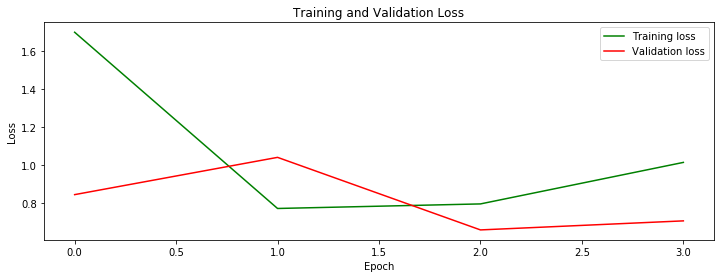

In [0]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [0]:
loss_hist

([1.6984996598043718,
  0.7711090035547457,
  0.7950981496478702,
  1.0135528854174822],
 [0.8439771626806502,
  1.040092054811225,
  0.6582862105466385,
  0.7058745487994955])

In [0]:
# torch.save(model.state_dict(), f'/content/gdrive/My Drive/data_sets/whale/{cnn_name}-whale-triplet-3.pth')

In [0]:
# model.load_state_dict(torch.load(f'/content/gdrive/My Drive/data_sets/whale/{cnn_name}-whale-triplet-3.pth'))

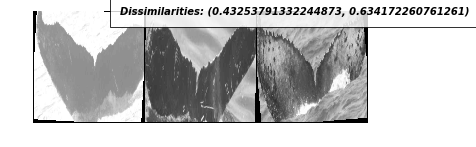

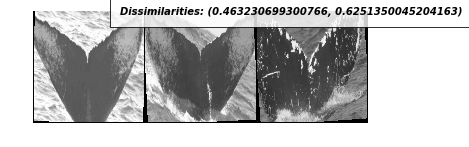

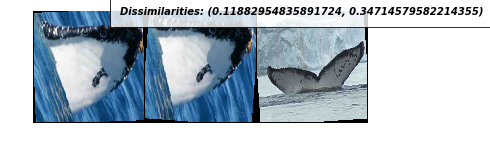

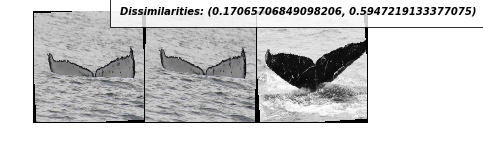

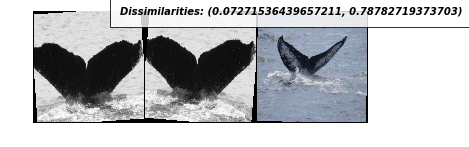

In [0]:
model.eval()
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=64)
dataiter = iter(test_dl)
for i in range(5):
    x0, x1, x2 = next(dataiter)
    concat = torch.cat((x0, x1, x2), 0)
    f0, f1, f2 = model(Variable(x0).cuda(), Variable(x1).cuda(), Variable(x2).cuda())
    pos_distance = F.pairwise_distance(f0, f1)
    neg_distance = F.pairwise_distance(f0, f2)
    imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.cpu().data[0]}, {neg_distance.cpu().data[0]})')

In [0]:
model.eval()
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=64)
dataiter = iter(test_dl)
for i in range(5):
    x0, x1, x2 = next(dataiter)
    print(type(x0))
    f0  , f1 , f2= model(x0.cuda() , x1.cuda() , x2.cuda())
    type(f0)
    
#     concat = torch.cat((x0, x1, x2), 0)
#     f0, f1, f2 = model(Variable(x0).cuda(), Variable(x1).cuda(), Variable(x2).cuda())
#     pos_distance = F.pairwise_distance(f0, f1)
#     neg_distance = F.pairwise_distance(f0, f2)
#     imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.cpu().data[0]}, {neg_distance.cpu().data[0]})')

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [0]:
print((f0.cpu().data.numpy()).shape)

(1, 128)
